<a href="https://colab.research.google.com/github/anruki/Quantum-Programming-Applications/blob/main/problema_optimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit_ibm_runtime

In [ ]:
pip install qiskit[visualization]

In [ ]:
pip install qiskit_aer

# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

We define a function for creating a circuit

In [ ]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import RZZGate, RXGate


def max_cut_hamiltonian(graph: rx.PyGraph) -> SparsePauliOp:
    terms = [["", [], 0.5 * graph.num_edges()]]
    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())


def qaoa_circuit(graph: rx.PyGraph, p: int) -> QuantumCircuit:
    betas = [Parameter(f"b_{i}") for i in range(p)]
    gammas = [Parameter(f"g_{i}") for i in range(p)]
    qubits = QuantumRegister(graph.num_nodes())
    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)
    for beta, gamma in zip(betas, gammas):
        for (i, j) in graph.edge_list():
            circuit.append(RZZGate(gamma), [qubits[i], qubits[j]])
        for q in qubits:
            circuit.append(RXGate(beta), [q])
    return circuit


n_qubits = 5
probability = 0.8
p = 1

graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)
observable = max_cut_hamiltonian(graph)
circuit = qaoa_circuit(graph, p=p)

In [ ]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[ 4.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j])

Cada combinación IIIII, IIIZZ, ...

Si solo tuviésemos 1 qubit sería : I, Z, X , ...

Letters are the initials of the linear combination of operators. (Pauli matrix)

And coefficients.

Queremos separar el grafo en 2 mitades y cortar el mayor número de líneas.

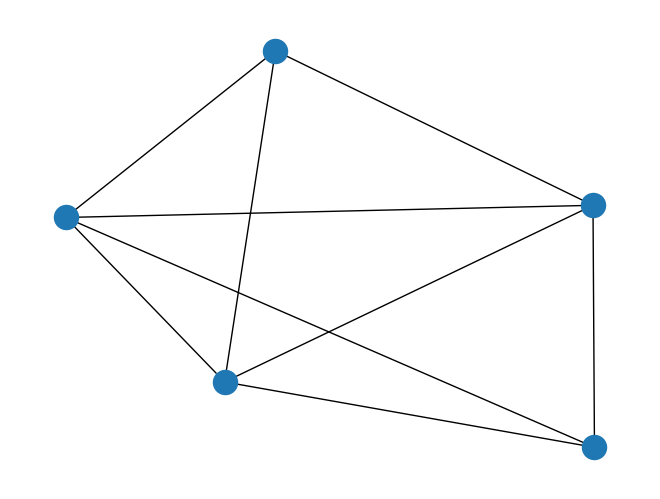

In [ ]:
from rustworkx.visualization import mpl_draw

mpl_draw(graph)

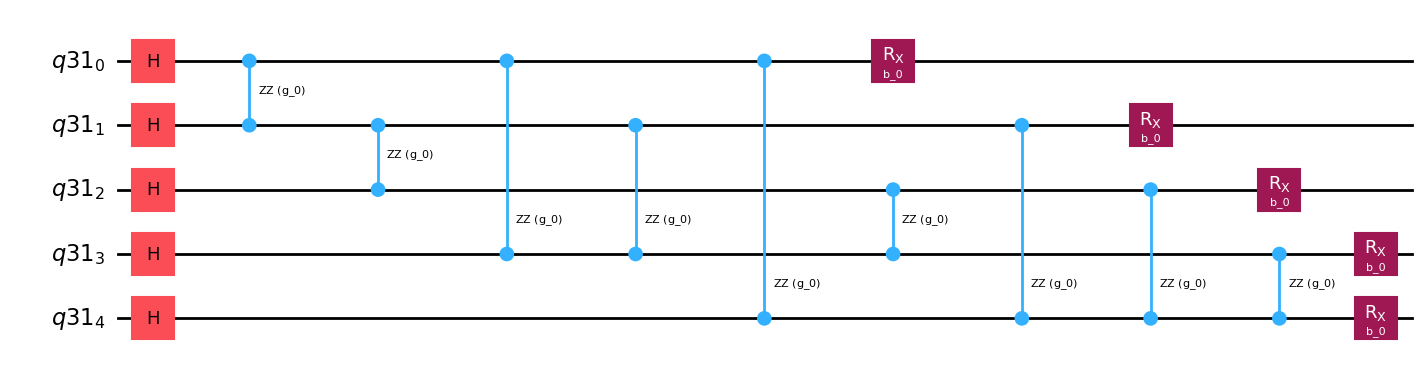

In [ ]:
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [ ]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[ 4.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j])

In [ ]:
isa_observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIII

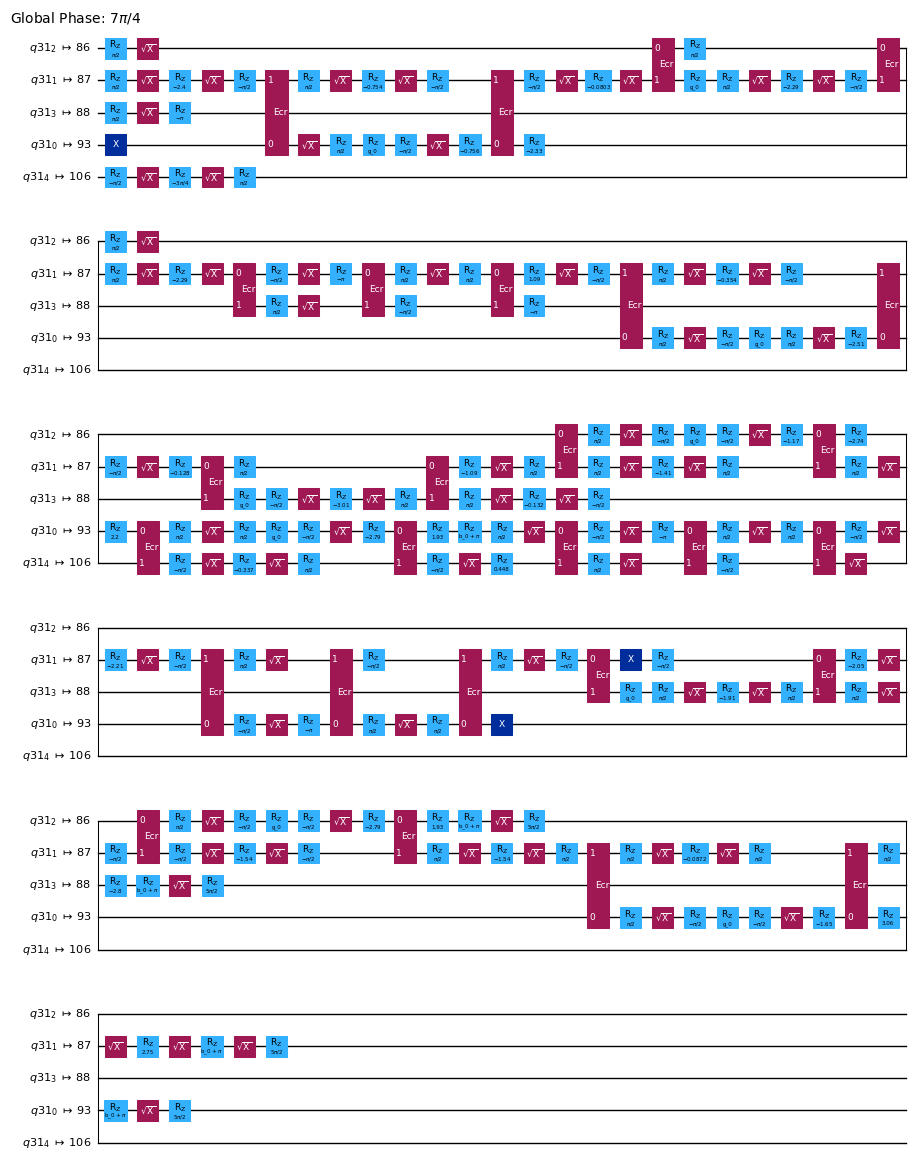

In [ ]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

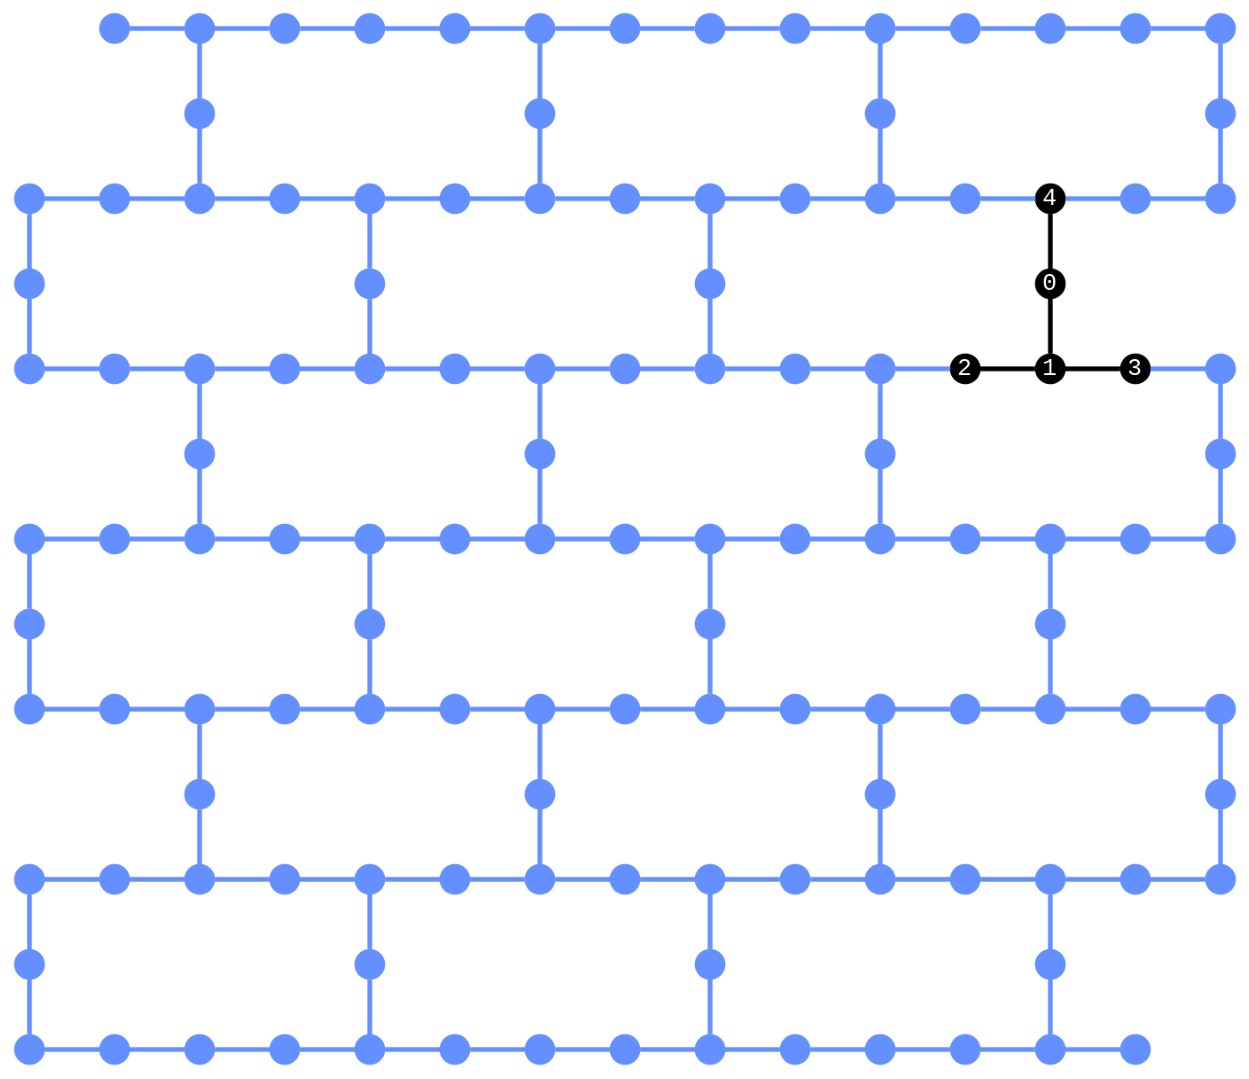

In [ ]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

Corta 4 líneas.

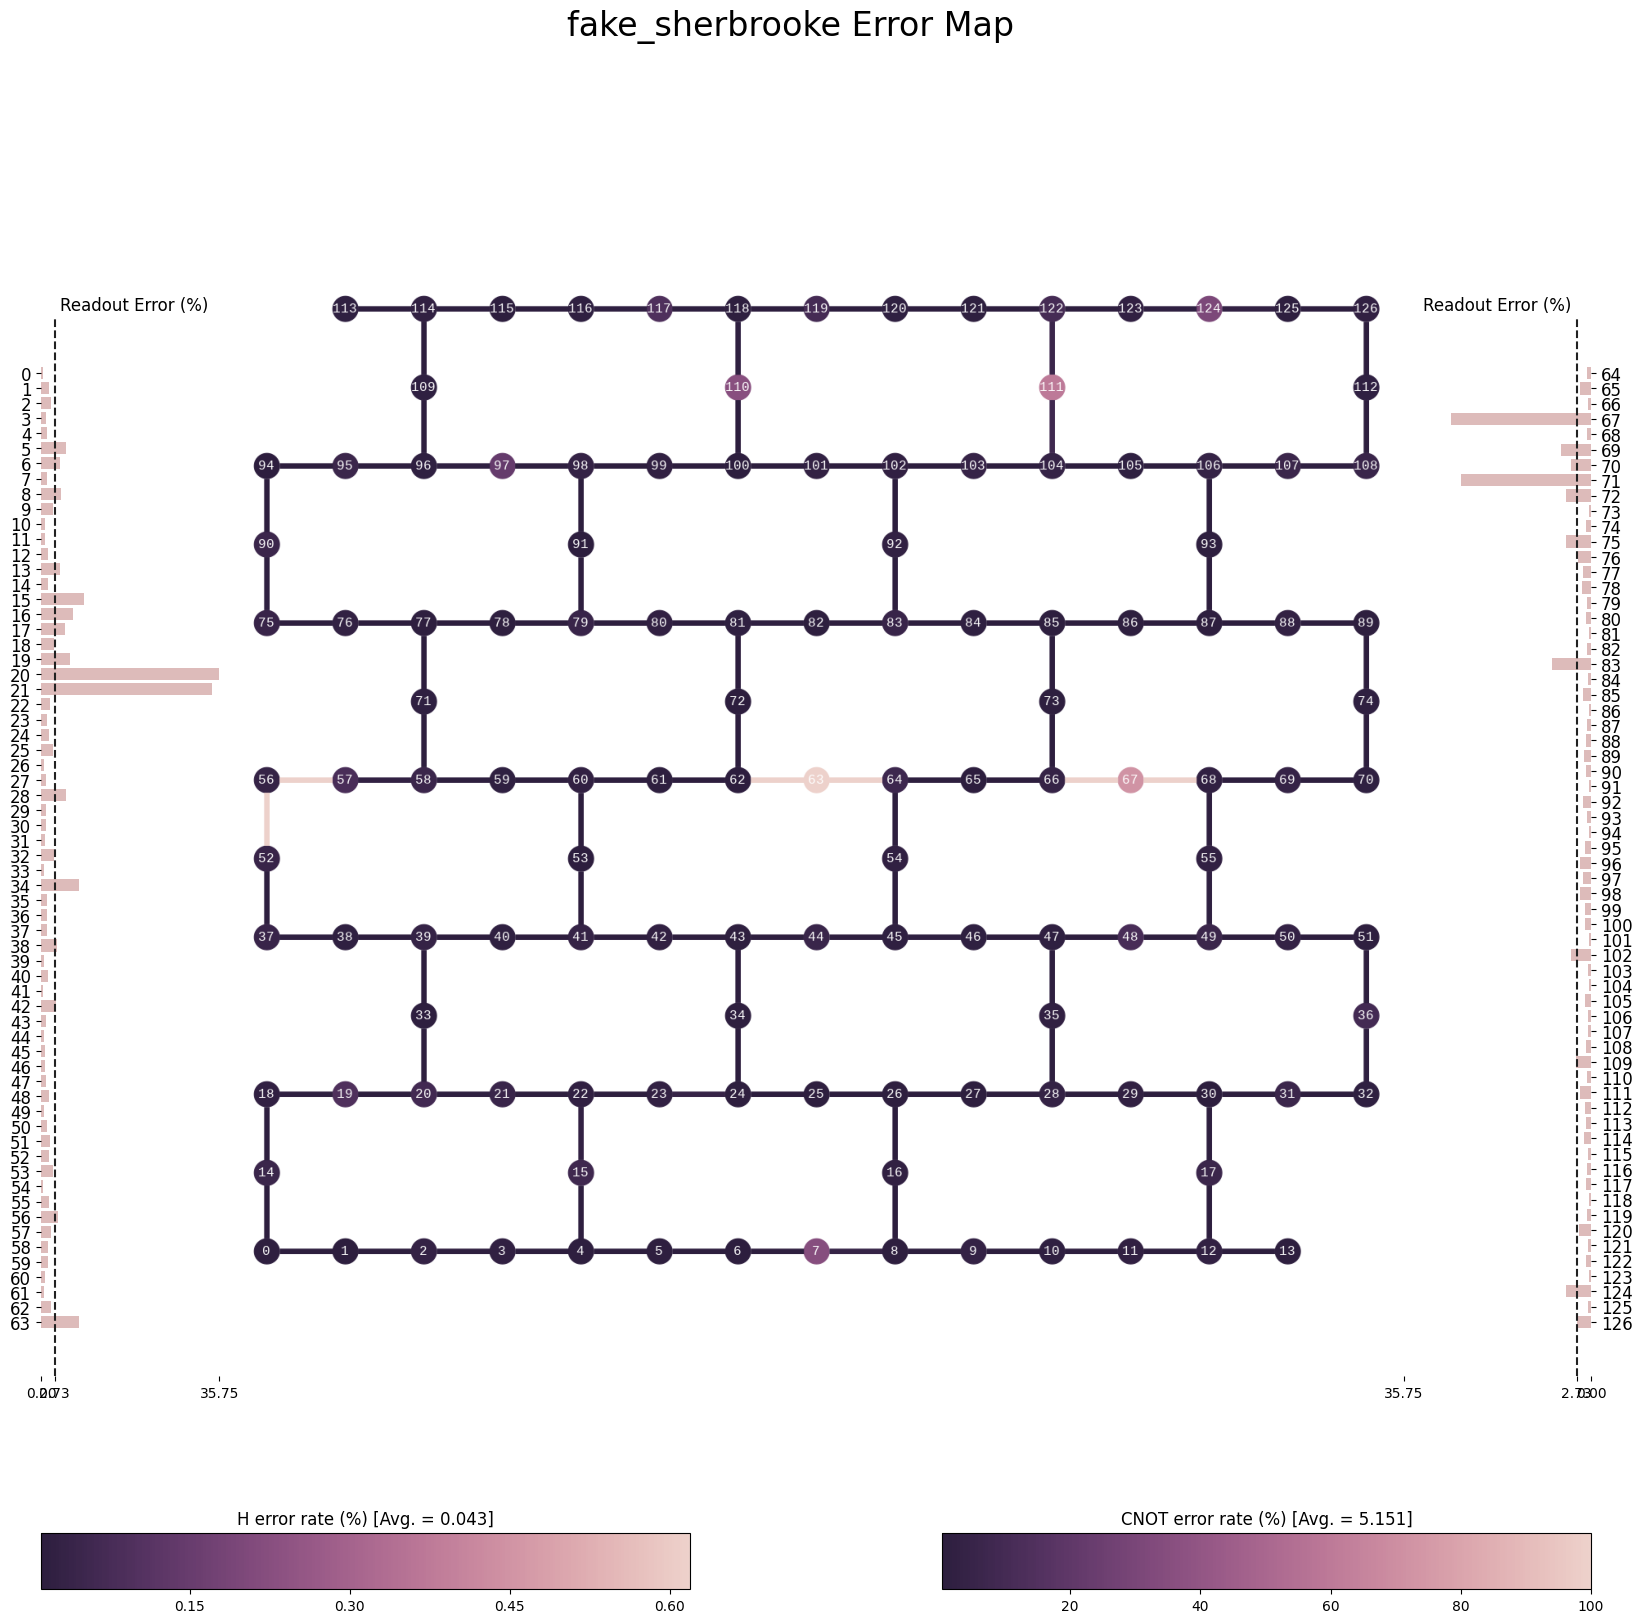

In [ ]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, figsize=(20, 20))

## Step 3: Execute circuits using Qiskit Primitives

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

rng = np.random.default_rng()
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)


estimator = Estimator(mode=backend)

pub = (isa_circuit, isa_observable, params)
job = estimator.run([pub])



---



Copiando el token de quantum.ibm.com

¡!OJO: solo hay disponibles 10mins de ejecución al mes

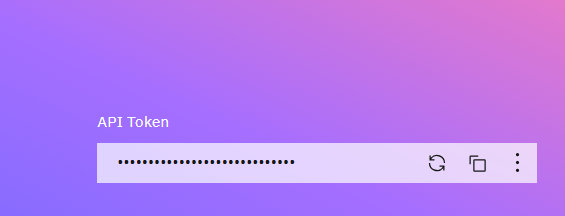

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='7730846c7e17b72f576bfd214226abb3651bf657245dfcfd6e208effd75cd4339fb0699218057736dcd4b71c0342137fa57d2637e82edc8c7f4c9a90e23e66bc'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='7730846c7e17b72f576bfd214226abb3651bf657245dfcfd6e208effd75cd4339fb0699218057736dcd4b71c0342137fa57d2637e82edc8c7f4c9a90e23e66bc')

Lista de las máquinas reales para runear el circuito.

In [ ]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_kyiv')>]

In [ ]:
b = service.backends()[0]



---



In [ ]:
result = job.result()
pub_result = result[0]
expectation_val = float(pub_result.data.evs)
expectation_val

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


BasicProviderError: 'Number of qubits 127 is greater than maximum (24) for "basic_simulator".'

In [ ]:
from qiskit_ibm_runtime import Session
import scipy.optimize


def f(x: np.ndarray, estimator: Estimator) -> float:
    pub = (isa_circuit, isa_observable, x)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    val = -float(pub_result.data.evs)
    print(f"Objective function value: {val}")
    return val


with Session(backend=backend):
    estimator = Estimator(mode=backend)
    result = scipy.optimize.minimize(
        f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)
    )

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


BasicProviderError: 'Number of qubits 127 is greater than maximum (24) for "basic_simulator".'

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# params = result.x

sampler = Sampler(backend=backend)

circuit_with_meas = circuit.copy()
circuit_with_meas.measure_all()
isa_circuit = pass_manager.run(circuit_with_meas)

pub = (isa_circuit, params)
job = sampler.run([pub])
result = job.result()
pub_result = result[0]
pub_result

## Step 4: Postprocess results into classical format

In [ ]:
counts = pub_result.data.meas.get_counts()

bitstring = max(counts, key=lambda x: counts[x])

In [ ]:
def cut_size(bitstring: str, graph: rx.PyGraph) -> int:
    return sum(bitstring[-i-1] != bitstring[-j-1] for i, j in graph.edge_list())

cut_size(bitstring, graph)

In [ ]:
colors = ["red" if b == "0" else "blue" for b in bitstring]

mpl_draw(graph, node_color=colors)